In [35]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.0.1+cu117
CUDA version: 11.7


In [36]:
!pip install japanize-matplotlib
!pip install torch-geometric

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import torch
from random import random
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

## 元のデータの読み込み

In [38]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルの読み込み
df = pd.read_csv('./experiment/dataset/contracts.csv')

# MultiGraphの作成
G = nx.MultiGraph()

# エッジの追加（重複を許可）
for _, row in df.iterrows():
    G.add_edge(row['from_address'], row['to_address'])

# グラフの基本情報を表示
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 312920
Number of edges: 464405


#### グラフの可視化(時間かかる)

In [39]:
# pos = nx.spring_layout(G, iterations=20, pos = nx.spring_layout(G, iterations=10, threshold=0.01))
# nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=5, arrowsize=1)
# plt.title("Generated Graph from CSV")

# plt.savefig("generated_graph.png", dpi=300, bbox_inches='tight')

In [40]:
from collections import Counter

degree = list(dict(nx.degree(G)).values())

print(max(degree))
print(min(degree))

# 次数の出現回数をカウント
degree_counts = Counter(degree)

# データフレームを作成
df = pd.DataFrame.from_dict(degree_counts, orient='index', columns=['頻度'])
df = df.sort_index()

print(df)

252851
1
            頻度
1       229339
2        59705
3        12416
4         3901
5         1695
...        ...
11000        1
12000        1
13411        1
36851        1
252851       1

[272 rows x 1 columns]


### 元データの次数散布図

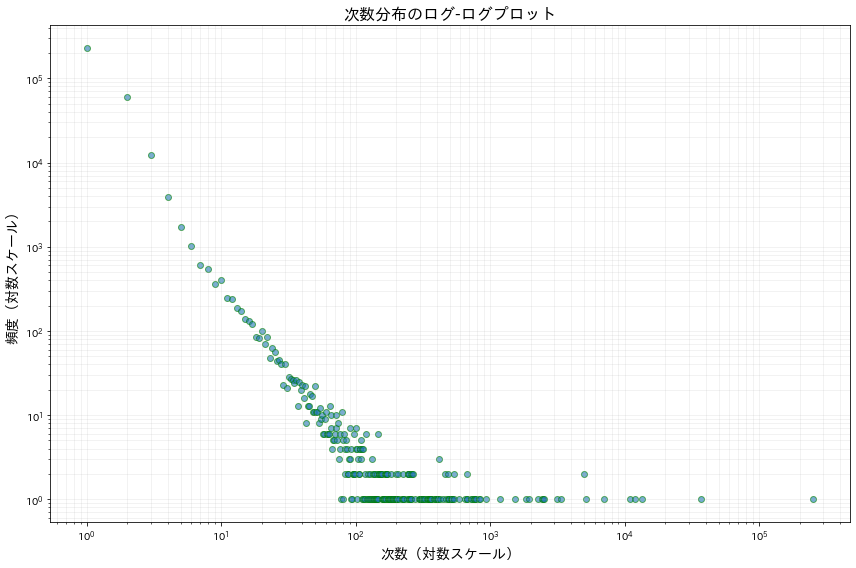

In [41]:
plt.figure(figsize=(12, 8))
plt.scatter(list(df.index), df['頻度'], alpha=0.6, edgecolors='g')
plt.xscale('log')
plt.yscale('log')

# 軸ラベルとタイトル
plt.xlabel('次数（対数スケール）', fontsize=14)
plt.ylabel('頻度（対数スケール）', fontsize=14)
plt.title('次数分布のログ-ログプロット', fontsize=16)

# グリッドの追加
plt.grid(True, which="both", ls="-", alpha=0.2)

# プロットの表示
plt.tight_layout()
plt.show()

## データセットの分割

In [42]:
""" テストデータのinput(トレインデータ作成用) """
df = pd.read_csv('./experiment/dataset/test_data.csv')

# MultiGraphの作成
G_test = nx.MultiGraph()

# エッジの追加（重複を許可）
for _, row in df.iterrows():
    G_test.add_edge(row['from_address'], row['to_address'])

# グラフの基本情報を表示
print(f"Number of nodes: {G_test.number_of_nodes()}")
print(f"Number of edges: {G_test.number_of_edges()}")

""" トレインデータのinput(テストデータ作成用) """

df = pd.read_csv('./experiment/dataset/train_data.csv')

G_train = nx.MultiGraph()

#エッジの追加
for _, row in df.iterrows():
    G_train.add_edge(row['from_address'], row['to_address'])

print(f"Number of train_nodes: {G_train.number_of_nodes()}")
print(f"Number of test_edges: {G_train.number_of_edges()}")

Number of nodes: 24284
Number of edges: 46441
Number of train_nodes: 295219
Number of test_edges: 417966


### データセット分割

In [43]:
#テストグラフの作成(ノードの数は一緒)
def remove_edges(G, edges_to_remove):
    G.remove_edges_from(edges_to_remove)
    G.remove_edges_from([(v, u) for (u, v) in edges_to_remove])

### 訓練データ

In [44]:
G_train = G.copy()
remove_edges(G_train, list(G_test.edges()))
print(f"Number of nodes: {G_train.number_of_nodes()}")
print(f"Number of edges: {G_train.number_of_edges()}")

Number of nodes: 312920
Number of edges: 412930


### テストデータ

In [45]:
G_test = G.copy()
remove_edges(G_test, list(G_train.edges()))
print(f"Number of test_nodes: {G_test.number_of_nodes()}")
print(f"Number of test_edges: {G_test.number_of_edges()}")

Number of test_nodes: 312920
Number of test_edges: 48344


## 実装

### GCN

#### 訓練データのedge_index化

In [46]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
import torch_geometric.utils as utils

# ノードに整数インデックスを割り当てる
node_to_index = {node: i for i, node in enumerate(G_train.nodes())}

# エッジリストを整数インデックスに変換
edge_list_int = [(node_to_index[u], node_to_index[v]) for u, v in G_train.edges()]

print(f"エッジ数：{len(edge_list_int)}")

num_nodes = len(G_train.nodes)

print(f"ノード数{num_nodes}")

embedding_dim = 128  # 埋め込み次元

# 整数インデックスのエッジリストをテンソルに変換
edge_index = torch.tensor(edge_list_int, dtype=torch.long).t().contiguous()

train_edge_index =  edge_index

print(edge_index)
# ノードの初期特徴量をランダムに設定
X = torch.randn((num_nodes, embedding_dim))

# PyTorch Geometric の Data オブジェクトを作成
data = Data(x=X, edge_index=edge_index)

エッジ数：412930
ノード数312920
tensor([[     0,      0,      0,  ..., 295168, 295180, 295205],
        [     1,    554,    554,  ..., 295169, 295181, 295206]])


In [47]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

Number of nodes: 312920
Number of edges: 412930


In [58]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# モデルの初期化
model = GCN(embedding_dim, 64, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [49]:
def predict_edge_prob(edge_index, z):
    edge_emb = z[edge_index[0]] * z[edge_index[1]]
    edge_prob = torch.sigmoid(edge_emb.sum(dim=1))
    return edge_prob

def binary_cross_entropy_loss(pos_edge_prob, neg_edge_prob):
    pos_loss = -torch.log(pos_edge_prob + 1e-15).mean()
    neg_loss = -torch.log(1 - neg_edge_prob + 1e-15).mean()
    return pos_loss + neg_loss

### 訓練用のエッジリストの作成

In [50]:
# CSVファイルを読み込む
df_negative_edges = pd.read_csv('./experiment/dataset/GCN_negative_edge.csv')

# リストに変換
negative_edges = df_negative_edges.values.tolist()

In [51]:
pos_edge_index = train_edge_index
neg_edge_index = torch.tensor(negative_edges, dtype=torch.long).t().contiguous()

### 学習

In [ ]:
# トレーニングループ
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    z = model(X, edge_index)

    # 正のエッジと負のエッジの存在確率の予測
    pos_edge_prob = predict_edge_prob(pos_edge_index, z)
    neg_edge_prob = predict_edge_prob(neg_edge_index, z)

    # 損失関数の計算
    loss = binary_cross_entropy_loss(pos_edge_prob, neg_edge_prob)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 2.5906918048858643
Epoch 1, Loss: 1.3859179019927979
Epoch 2, Loss: 1.1592854261398315
Epoch 3, Loss: 1.236433506011963
Epoch 4, Loss: 1.2273415327072144
Epoch 5, Loss: 1.1365470886230469
Epoch 6, Loss: 1.0236034393310547
Epoch 7, Loss: 0.9620023965835571
Epoch 8, Loss: 0.9150417447090149
Epoch 9, Loss: 0.9072891473770142
Epoch 10, Loss: 0.9003813862800598
Epoch 11, Loss: 0.8861444592475891
Epoch 12, Loss: 0.8819343447685242
Epoch 13, Loss: 0.8702443242073059
Epoch 14, Loss: 0.8609659671783447
Epoch 15, Loss: 0.860462486743927
Epoch 16, Loss: 0.8478593826293945
Epoch 17, Loss: 0.8436150550842285
Epoch 18, Loss: 0.8513866662979126
Epoch 19, Loss: 0.846174418926239
Epoch 20, Loss: 0.8403841257095337
Epoch 21, Loss: 0.837346076965332
Epoch 22, Loss: 0.8340162634849548
Epoch 23, Loss: 0.8346619009971619
Epoch 24, Loss: 0.8317292928695679
Epoch 25, Loss: 0.8286949992179871
Epoch 26, Loss: 0.8289278149604797
Epoch 27, Loss: 0.8246740102767944
Epoch 28, Loss: 0.826852023601532


### テストデータの特徴量作成

In [53]:
# ノードに整数インデックスを割り当てる
node_to_index = {node: i for i, node in enumerate(G_test.nodes())}

# エッジリストを整数インデックスに変換
edge_list_int = [(node_to_index[u], node_to_index[v]) for u, v in G_test.edges()]

print(f"エッジ数：{len(edge_list_int)}")

num_nodes = len(G_test.nodes)

embedding_dim = 128  # 埋め込み次元

# 整数インデックスのエッジリストをテンソルに変換
test_edge_index = torch.tensor(edge_list_int, dtype=torch.long).t().contiguous()
# ノードの初期特徴量をランダムに設定
X = torch.randn((num_nodes, embedding_dim))

# PyTorch Geometric の Data オブジェクトを作成
data = Data(x=X, edge_index=test_edge_index)

print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

エッジ数：48344
Number of nodes: 312920
Number of edges: 48344


In [54]:
# CSVファイルを読み込む
df_negative_edges = pd.read_csv('./experiment/dataset/negative_edges.csv')

# リストに変換
negative_edges = df_negative_edges.values.tolist()

In [55]:
test_pos_edge_index = test_edge_index
test_neg_edge_index = torch.tensor(negative_edges, dtype=torch.long).t().contiguous()

ROC AUC Score: 0.9147


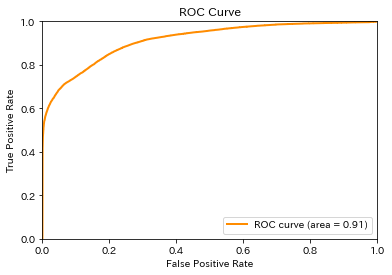

In [56]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import torch

# 評価
model.eval()
with torch.no_grad():
    z = model(X, test_edge_index)
    
    # テストデータの準備
    test_pos_prob = predict_edge_prob(test_pos_edge_index, z)
    test_neg_prob = predict_edge_prob(test_neg_edge_index, z)
    
    # 予測確率を結合
    y_pred = torch.cat([test_pos_prob, test_neg_prob])
    
    # 正解ラベルの作成
    y_true = torch.cat([
        torch.ones(test_pos_prob.size(0)), 
        torch.zeros(test_neg_prob.size(0))
    ])
    
    # シャッフル用のインデックスを生成
    shuffle_idx = torch.randperm(len(y_true))

    
    # データをシャッフル
    y_true = y_true[shuffle_idx]
    y_pred = y_pred[shuffle_idx]
    
    # numpy配列に変換
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    # ROC AUCスコアの計算
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'ROC AUC Score: {roc_auc:.4f}')

    # ROC曲線の描画
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

##### F1score

F1 Score: 0.7327


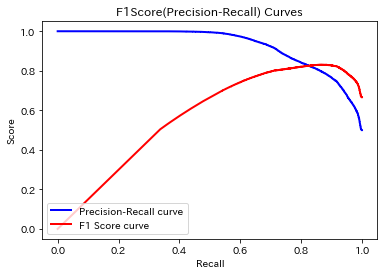

In [57]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

# y_predを二値化するための閾値を設定
threshold = 0.5

# y_predを二値化
y_pred_binary = (np.array(y_pred) >= threshold).astype(int)

# F1スコアの計算
f1 = f1_score(y_true, y_pred_binary)
print(f'F1 Score: {f1:.4f}')

# 適合率と再現率の曲線を計算
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# 各閾値でのF1スコアを計算
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)  # NaNを0に置換

plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.plot(recall, f1_scores, color='r', lw=2, label='F1 Score curve')
plt.xlabel('Recall')
plt.ylabel('Score')
plt.title('F1Score(Precision-Recall) Curves')
plt.legend(loc="lower left")
plt.show()